# Neural & Behavioral Modeling - Week 14 (Exercises)
趙冠豪 (B05901180)

In [1]:
# Upgrade PyTorch to 0.4.0 if necessary:
! conda install -y pytorch-cpu torchvision-cpu -c pytorch

Solving environment: failed

PackagesNotFoundError: The following packages are not available from current channels:

  - torchvision-cpu
  - pytorch-cpu

Current channels:

  - https://conda.anaconda.org/pytorch/osx-64
  - https://conda.anaconda.org/pytorch/noarch
  - https://repo.anaconda.com/pkgs/main/osx-64
  - https://repo.anaconda.com/pkgs/main/noarch
  - https://repo.anaconda.com/pkgs/free/osx-64
  - https://repo.anaconda.com/pkgs/free/noarch
  - https://repo.anaconda.com/pkgs/r/osx-64
  - https://repo.anaconda.com/pkgs/r/noarch
  - https://repo.anaconda.com/pkgs/pro/osx-64
  - https://repo.anaconda.com/pkgs/pro/noarch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.




In [116]:
%config IPCompleter.greedy=True 
%matplotlib inline
import matplotlib.pyplot as plt 
from IPython.display import *
import numpy as np
from torch.autograd import Variable
import pylab as pl
import torch.nn.init as init

In [117]:
# Check GPU status:
import torch as t
t.manual_seed(1)    # for reproduction
print('PyTorch version:',t.__version__)
use_cuda=t.cuda.is_available()
if(use_cuda):
    for i in range(t.cuda.device_count()):
        print('Device ',i,':',t.cuda.get_device_name(i))
    print('Current: Device ',t.cuda.current_device())
    t.backends.cudnn.benchmark = True 
    device = t.device("cuda")
else:
    device = t.device("cpu")
    print('No GPU')

PyTorch version: 0.4.0
No GPU


## 1 Activation/Signal Function in RNN (10 points)

tanh(x) is a more popular choice of activation function than sigmoid(x) & relu(x) in contemporary RNNs.
Below please use simple RNN to compare 3 activation functions in terms of their learning efficiency and capacity. If there is any significant difference, please discuss why. 

nn.RNN(..., nonlinearity='relu') allows you to switch tanh to relu. However, you need some deep hacking of the source code to replace nn.Tanh with nn.Sigmoid. Alternatively, you can <a href="https://www.cpuheater.com/deep-learning/introduction-to-recurrent-neural-networks-in-pytorch/">code a simple RNN from scratch</a> to have a better control of everything!

### 1.0 Data: sin(t) → cos(t)

In [118]:
steps = np.linspace(0, np.pi*2, 100, dtype=np.float32)
steps


array([ 0.        ,  0.06346652,  0.12693304,  0.19039956,  0.25386608,
        0.3173326 ,  0.38079911,  0.44426563,  0.50773215,  0.57119864,
        0.63466519,  0.69813168,  0.76159823,  0.82506472,  0.88853127,
        0.95199776,  1.01546431,  1.07893085,  1.14239728,  1.20586383,
        1.26933038,  1.33279693,  1.39626336,  1.45972991,  1.52319646,
        1.58666301,  1.65012944,  1.71359599,  1.77706254,  1.84052908,
        1.90399551,  1.96746206,  2.03092861,  2.09439516,  2.15786171,
        2.22132802,  2.28479457,  2.34826112,  2.41172767,  2.47519422,
        2.53866076,  2.60212731,  2.66559386,  2.72906017,  2.79252672,
        2.85599327,  2.91945982,  2.98292637,  3.04639292,  3.10985947,
        3.17332602,  3.23679233,  3.30025887,  3.36372542,  3.42719197,
        3.49065852,  3.55412507,  3.61759162,  3.68105817,  3.74452448,
        3.80799103,  3.87145758,  3.93492413,  3.99839067,  4.06185722,
        4.12532377,  4.18879032,  4.25225687,  4.31572342,  4.37

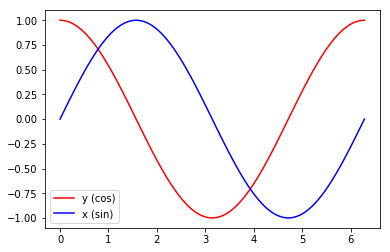

In [119]:
steps = np.linspace(0, np.pi*2, 100, dtype=np.float32)
x_np = np.sin(steps)
y_np = np.cos(steps)
plt.plot(steps, y_np, 'r-', label='y (cos)')
plt.plot(steps, x_np, 'b-', label='x (sin)')
plt.legend(loc='best');

### 1.1 RNN model for 1D-to-1D time-series regression (7 points)

### >my code below

I try to modify different activation function in 'forward function'. I follow the training steps from the link that teacher provide

**1. 'tanh' activation function**

In [491]:
dtype = t.FloatTensor
input_size, hidden_size, output_size = 7, 6, 1
epochs = 300
seq_length = 20
lr = 0.1

In [492]:
data_time_steps = np.linspace(2, 10, seq_length + 1)
data = np.sin(data_time_steps)
data.resize((seq_length + 1, 1))

x = Variable(t.Tensor(data[:-1]).type(dtype), requires_grad=False)
y = Variable(t.Tensor(data[1:]).type(dtype), requires_grad=False)

In [493]:
data = np.sin(data_time_steps)

In [494]:
data

array([ 0.90929743,  0.67546318,  0.33498815, -0.05837414, -0.44252044,
       -0.7568025 , -0.95160207, -0.99616461, -0.88345466, -0.63126664,
       -0.2794155 ,  0.1165492 ,  0.49411335,  0.79366786,  0.96791967,
        0.98935825,  0.85459891,  0.58491719,  0.22288991, -0.17432678,
       -0.54402111])

In [495]:
w1 = t.FloatTensor(input_size, hidden_size).type(dtype)
init.normal(w1, 0.0, 0.4)
w1 =  Variable(w1, requires_grad=True)
w2 = t.FloatTensor(hidden_size, output_size).type(dtype)
init.normal(w2, 0.0, 0.3)
w2 = Variable(w2, requires_grad=True)

/Users/Kuan-Hao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  
/Users/Kuan-Hao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  """


In [496]:
def forward(input, context_state, w1, w2):
    xh = t.cat((input, context_state), 1)
    context_state = t.tanh(xh.mm(w1))
    out = context_state.mm(w2)
    return  (out, context_state)

In [497]:
for i in range(epochs):
    total_loss = 0
    context_state = Variable(t.zeros((1, hidden_size)).type(dtype), requires_grad=True)
    for j in range(x.size(0)):
        input = x[j:(j+1)]
        target = y[j:(j+1)]
        (pred, context_state) = forward(input, context_state, w1, w2)
        loss = (pred - target).pow(2).sum()/2
        total_loss += loss
        loss.backward()
        w1.data -= lr * w1.grad.data
        w2.data -= lr * w2.grad.data
        w1.grad.data.zero_()
        w2.grad.data.zero_()
        context_state = Variable(context_state.data)
    if i % 10 == 0:
        print("Epoch: {} loss {}".format(i, total_loss.data[0]))

/Users/Kuan-Hao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 0 loss 1.077009916305542
Epoch: 10 loss 0.20088103413581848
Epoch: 20 loss 0.1829497069120407
Epoch: 30 loss 0.17391160130500793
Epoch: 40 loss 0.16809312999248505
Epoch: 50 loss 0.16332034766674042
Epoch: 60 loss 0.15867404639720917
Epoch: 70 loss 0.15372583270072937
Epoch: 80 loss 0.14826613664627075
Epoch: 90 loss 0.1422090381383896
Epoch: 100 loss 0.1355638951063156
Epoch: 110 loss 0.12843057513237
Epoch: 120 loss 0.12100140750408173
Epoch: 130 loss 0.11355558782815933
Epoch: 140 loss 0.10643085092306137
Epoch: 150 loss 0.09996701031923294
Epoch: 160 loss 0.0944342315196991
Epoch: 170 loss 0.08997515588998795
Epoch: 180 loss 0.08659179508686066
Epoch: 190 loss 0.08417432755231857
Epoch: 200 loss 0.08255062252283096
Epoch: 210 loss 0.0815296322107315
Epoch: 220 loss 0.08092847466468811
Epoch: 230 loss 0.08058648556470871
Epoch: 240 loss 0.08037542551755905
Epoch: 250 loss 0.08020639419555664
Epoch: 260 loss 0.08003539592027664
Epoch: 270 loss 0.0798640102148056
Epoch: 280 los

In [498]:
context_state = Variable(t.zeros((1, hidden_size)).type(dtype), requires_grad=False)
predictions = []
 
for i in range(x.size(0)):
    input = x[i:i+1]
    (pred, context_state) = forward(input, context_state, w1, w2)
    context_state = context_state
    predictions.append(pred.data.numpy().ravel()[0])

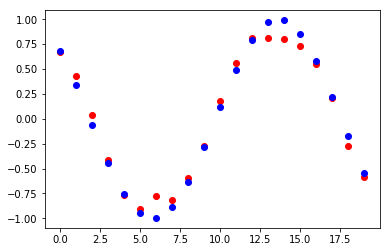

In [499]:
plt.plot(predictions, "ro", label='prediction')
plt.plot(np.sin(data_time_steps[1:]), 'bo', label='target')

**2. 'relu' activation function**

In [442]:
def forward(input, context_state, w1, w2):
    xh = t.cat((input, context_state), 1)
    context_state = t.relu(xh.mm(w1))
    out = context_state.mm(w2)
    return  (out, context_state)

In [443]:
for i in range(epochs):
    total_loss = 0
    context_state = Variable(t.zeros((1, hidden_size)).type(dtype), requires_grad=True)
    for j in range(x.size(0)):
        input = x[j:(j+1)]
        target = y[j:(j+1)]
        (pred, context_state) = forward(input, context_state, w1, w2)
        loss = (pred - target).pow(2).sum()/2
        total_loss += loss
        loss.backward()
        w1.data -= lr * w1.grad.data
        w2.data -= lr * w2.grad.data
        w1.grad.data.zero_()
        w2.grad.data.zero_()
        context_state = Variable(context_state.data)
    if i % 10 == 0:
        print("Epoch: {} loss {}".format(i, total_loss.data[0]))

/Users/Kuan-Hao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 0 loss 0.32661551237106323
Epoch: 10 loss 0.32440418004989624
Epoch: 20 loss 0.32322394847869873
Epoch: 30 loss 0.32227110862731934
Epoch: 40 loss 0.3202386200428009
Epoch: 50 loss 0.32583877444267273
Epoch: 60 loss 0.32546699047088623
Epoch: 70 loss 0.32521557807922363
Epoch: 80 loss 0.3247508108615875
Epoch: 90 loss 0.3216037154197693
Epoch: 100 loss 0.32481345534324646
Epoch: 110 loss 0.32346343994140625
Epoch: 120 loss 0.32079342007637024
Epoch: 130 loss 0.32103151082992554
Epoch: 140 loss 0.3261336088180542
Epoch: 150 loss 0.31994155049324036
Epoch: 160 loss 0.32157042622566223
Epoch: 170 loss 0.3280011713504791
Epoch: 180 loss 0.3248289227485657
Epoch: 190 loss 0.32247668504714966
Epoch: 200 loss 0.32173484563827515
Epoch: 210 loss 0.32312917709350586
Epoch: 220 loss 0.3366624116897583
Epoch: 230 loss 0.32195618748664856
Epoch: 240 loss 0.33689284324645996
Epoch: 250 loss 0.33180099725723267
Epoch: 260 loss 0.33412936329841614
Epoch: 270 loss 0.3268222212791443
Epoch: 280 

In [444]:
context_state = Variable(t.zeros((1, hidden_size)).type(dtype), requires_grad=False)
predictions = []
 
for i in range(x.size(0)):
    input = x[i:i+1]
    (pred, context_state) = forward(input, context_state, w1, w2)
    context_state = context_state
    predictions.append(pred.data.numpy().ravel()[0])

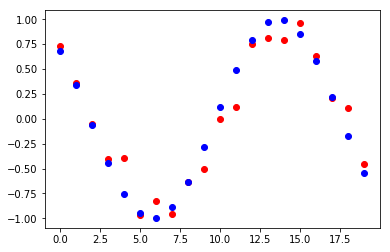

In [445]:
plt.plot(predictions, "ro", label='prediction')
plt.plot(np.sin(data_time_steps[1:]), 'bo', label='target')

**1. 'sigmoid' activation function**

In [500]:
def forward(input, context_state, w1, w2):
    xh = t.cat((input, context_state), 1)
    context_state = t.sigmoid(xh.mm(w1))
    out = context_state.mm(w2)
    return  (out, context_state)

In [501]:
for i in range(epochs):
    total_loss = 0
    context_state = Variable(t.zeros((1, hidden_size)).type(dtype), requires_grad=True)
    for j in range(x.size(0)):
        input = x[j:(j+1)]
        target = y[j:(j+1)]
        (pred, context_state) = forward(input, context_state, w1, w2)
        loss = (pred - target).pow(2).sum()/2
        total_loss += loss
        loss.backward()
        w1.data -= lr * w1.grad.data
        w2.data -= lr * w2.grad.data
        w1.grad.data.zero_()
        w2.grad.data.zero_()
        context_state = Variable(context_state.data)
    if i % 10 == 0:
        print("Epoch: {} loss {}".format(i, total_loss.data[0]))

/Users/Kuan-Hao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 0 loss 9.584457397460938
Epoch: 10 loss 1.3161768913269043
Epoch: 20 loss 0.8818637132644653
Epoch: 30 loss 0.7871417999267578
Epoch: 40 loss 0.7320564985275269
Epoch: 50 loss 0.685245156288147
Epoch: 60 loss 0.6429367065429688
Epoch: 70 loss 0.6046749949455261
Epoch: 80 loss 0.5705875754356384
Epoch: 90 loss 0.540919303894043
Epoch: 100 loss 0.5157875418663025
Epoch: 110 loss 0.4949895739555359
Epoch: 120 loss 0.4779016375541687
Epoch: 130 loss 0.4635421633720398
Epoch: 140 loss 0.4507558047771454
Epoch: 150 loss 0.43845611810684204
Epoch: 160 loss 0.4258177876472473
Epoch: 170 loss 0.41235846281051636
Epoch: 180 loss 0.39791345596313477
Epoch: 190 loss 0.382546067237854
Epoch: 200 loss 0.36644551157951355
Epoch: 210 loss 0.34984877705574036
Epoch: 220 loss 0.3329871594905853
Epoch: 230 loss 0.31606653332710266
Epoch: 240 loss 0.2992551326751709
Epoch: 250 loss 0.28268641233444214
Epoch: 260 loss 0.2664644420146942
Epoch: 270 loss 0.2506689429283142
Epoch: 280 loss 0.2353594303

In [502]:
context_state = Variable(t.zeros((1, hidden_size)).type(dtype), requires_grad=False)
predictions = []
 
for i in range(x.size(0)):
    input = x[i:i+1]
    (pred, context_state) = forward(input, context_state, w1, w2)
    context_state = context_state
    predictions.append(pred.data.numpy().ravel()[0])

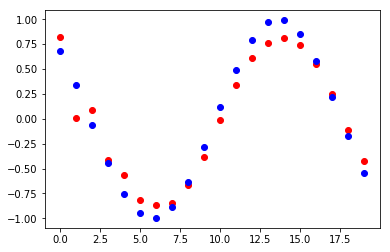

In [503]:
plt.plot(predictions, "ro", label='prediction')
plt.plot(np.sin(data_time_steps[1:]), 'bo', label='target')

### 1.2 Conclusions (3 points)

Please write your discussion here.

經過多次的觀察之後，我發現的以下的現象：
1. relu 的近似效果對於 sin函數來說最差。(形狀會偏離原本的函數，有
2. sigmod 和 tanh 的效果都還不錯

![](https://i.imgur.com/8uoEQhl.png)
![](https://i.imgur.com/YA7tFJv.png)



推測原因： 用Relu當作 activation function 的 modle 都是用線性近似的（每一小段都是直線）。需要更多的training loop 才可以接近smooth funciton. 如果使用 tanh 或者 sigmoid 效果則比較好。